In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Chargement des données
file_path = r"C:\\Users\\dariu\\Desktop\\Anomaly-detection-in-Microservices-based-systems\\application anomalies dataset\\data1.csv"
df = pd.read_csv(file_path)
features = ["99th quantile", "50th quantile", "Mean", "2xx", "4xx/5xx"]
X = df[features]
y = df["IsError"].astype(int)

# Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape pour LSTM : (samples, timesteps=1, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data
X_train_lstm, X_test_lstm, X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_lstm, X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
# Entrée LSTM
input_lstm = Input(shape=(1, X_train_lstm.shape[2]))
lstm_out = LSTM(16, return_sequences=False)(input_lstm)

# Entrée MLP
input_mlp = Input(shape=(X_train_raw.shape[1],))
mlp_out = Dense(8, activation='relu')(input_mlp)

# Fusion des deux
merged = Concatenate()([lstm_out, mlp_out])
dense1 = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[input_lstm, input_mlp], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
# Entraînement
history = model.fit(
    [X_train_lstm, X_train_raw], y_train,
    epochs=10, batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5275 - loss: 0.6908 - val_accuracy: 0.5556 - val_loss: 0.6897
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5700 - loss: 0.6888 - val_accuracy: 0.5610 - val_loss: 0.6875
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5708 - loss: 0.6855 - val_accuracy: 0.5519 - val_loss: 0.6857
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5654 - loss: 0.6821 - val_accuracy: 0.5537 - val_loss: 0.6840
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5699 - loss: 0.6796 - val_accuracy: 0.5519 - val_loss: 0.6827
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5544 - loss: 0.6823 - val_accuracy: 0.5483 - val_loss: 0.6820
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5648 - loss: 0.6768 - val_accuracy: 0.5574 - val_loss: 0.6773
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5601 - loss: 0.6767 - val_accuracy: 0.5537 - val_loss

In [5]:
# Prédictions
y_pred_proba = model.predict([X_test_lstm, X_test_raw])
y_pred = (y_pred_proba > 0.6).astype(int).flatten()

# Métriques
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 0.52
Precision: 0.62
Recall: 0.12
F1-Score: 0.20


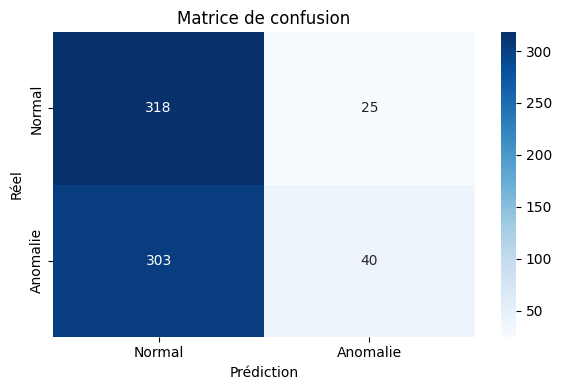

In [6]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


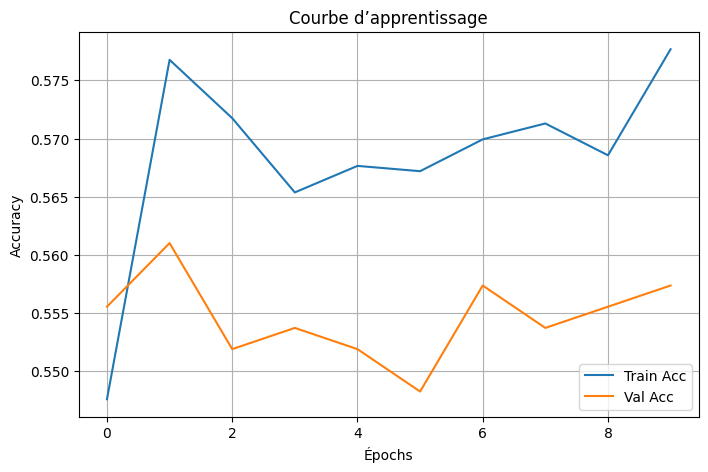

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Courbe d’apprentissage")
plt.xlabel("Épochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


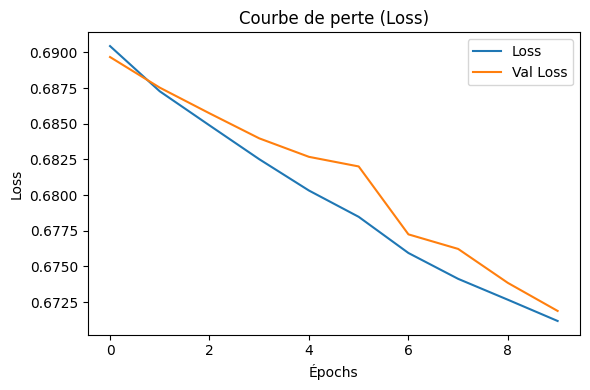

In [8]:
# Courbe de perte
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de perte (Loss)")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()